In [76]:
pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


In [77]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# replay memory class 
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [78]:
# Neural Net
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
       

    # Called with either one element to determine next action, or a batch
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.dropout(x, p=0.5)
        x = self.layer3(x)
        return x



In [79]:
class Agent():

    def __init__(self, state, n_actions):
        self.memory = ReplayMemory(1000000)
        self.n_actions = n_actions

        self.n_observations = len(state)
        self.eps = EPS_START

        self.policy_net = DQN(self.n_observations, self.n_actions).to(device)

        self.target_net = DQN(self.n_observations, self.n_actions).to(device)

        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        

    def select_action(self, state):
        
        # epsilon greedy action selection
        sample = random.random()
        


        if sample > self.eps:
            
          # decay epsilon
            if self.eps > EPS_END:
                self.eps *= EPS_DECAY
                
          # greedy selection
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            
          # decay epsilon
            if self.eps > EPS_END:
                self.eps *= EPS_DECAY
                
          # random selection
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    def select_test_action(self, state):
     
        return self.policy_net(state).max(1)[1].view(1, 1)
        


    def optimize(self):
        if len(agent.memory) < BATCH_SIZE:
            
            return
        # get transitions from replaymemory
        transitions = agent.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))


        # boolean mapping of TF for terminal or nonterminal states
        non_terminal_states = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), device=device, dtype=torch.bool)
        # get non terminal next states
        non_terminal_next_states = torch.cat([s for s in batch.next_state if s is not None])

        # get next state values and set terminal states to 0
        next_state_batch = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_batch[non_terminal_states] = agent.target_net(
                non_terminal_next_states).max(1)[0]
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a)
        state_action_values = agent.policy_net(state_batch).gather(1, action_batch)

            
        # Compute the expected Q values
        expected_state_action_values = (next_state_batch * GAMMA) + reward_batch
        # Compute loss
        criterion = nn.MSELoss()
        loss = criterion(state_action_values,
                        expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()



In [80]:
def test(env, agent):
    agent.policy_net.eval()
    agent.target_net.eval()
    
    # Initialize the environment and get it's state
    state, info = env.reset()

    # save the state in tensor form
    state = torch.tensor(state, dtype=torch.float32,
                         device=device).unsqueeze(0)

    score = 0
    done = False
    
    for i in range(1000):
        
        # select action with the agent
        action = agent.select_test_action(state)

        # take the action select in the environment
        observation, reward, terminated, truncated, _ = env.step(action.item())

        # done = seeing if the next state is terminal
        done = terminated or truncated
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(
                observation, dtype=torch.float32, device=device).unsqueeze(0)
        # save the reward in tensor form 
        reward = torch.tensor([reward], device=device)
        score += reward
        state = next_state

        if done:
            break
    return score

In [81]:
#  the number of transitions sampled from the replay buffer
BATCH_SIZE = 128

# the discount factor as mentioned in the previous section
GAMMA = 0.99

# the starting value of epsilon
EPS_START = 0.9

# the final value of epsilon
EPS_END = 0.05

# controls the rate of decay of epsilon, higher means a slower decay
EPS_DECAY = 0.99

# learning rate of the optimizer
LR = 0.001

# initialize the environment
env = gym.make("CartPole-v1", render_mode="rgb_array")
test_env = gym.make("CartPole-v1", render_mode="rgb_array")
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define what a transition should be in the replay memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
num_episodes = 500
# initialize the environment state, actions, and observations
state, _ = env.reset()
n_actions = env.action_space.n
n_observations = len(state)

# declare a DQN Agent with environment parameters
agent = Agent(state=state, n_actions=env.action_space.n)
scores = []
x = []
test_scores = []
# training loop
for i_episode in range(num_episodes):
    
    agent.policy_net.train()
    agent.target_net.train()
    
    # Initialize the environment and get it's state
    state, info = env.reset()

    # save the state in tensor form
    state = torch.tensor(state, dtype=torch.float32,
                         device=device).unsqueeze(0)

    score = 0
    done = False
    
    for i in range(1000):
        # select action with the agent
        action = agent.select_action(state)

        # take the action select in the environment
        observation, reward, terminated, truncated, _ = env.step(action.item())

        # done = seeing if the next state is terminal
        done = terminated or truncated

        # save the reward in tensor form 
        reward = torch.tensor([reward], device=device)
        score += reward

        # if next state is terminal save as None
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(
                observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        agent.memory.push(state, action, next_state, reward)
        
        
        
        
        # Perform one step of the optimization (on the policy network)
        agent.optimize()

        # Move to the next state
        state = next_state


        # Update every C=5 steps
        if i % 5 == 0:
            target_net_state_dict = agent.target_net.state_dict()
            policy_net_state_dict = agent.policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]
            agent.target_net.load_state_dict(target_net_state_dict)

        # breaking the loop if next state is terminal
        if done:
            break
    test_score = test(test_env, agent)

    scores.append(score.item())
    test_scores.append(test_score.item())
    x.append(i_episode)

    # print the score after each episode
    print('episode:', i_episode)
    print('train_score:', score.item())
    print('test_score:', test_score.item())
    print()


episode: 0
train_score: 23.0
test_score: 11.0

episode: 1
train_score: 15.0
test_score: 9.0

episode: 2
train_score: 21.0
test_score: 10.0

episode: 3
train_score: 16.0
test_score: 10.0

episode: 4
train_score: 11.0
test_score: 9.0

episode: 5
train_score: 13.0
test_score: 9.0

episode: 6
train_score: 13.0
test_score: 10.0

episode: 7
train_score: 10.0
test_score: 10.0

episode: 8
train_score: 10.0
test_score: 10.0

episode: 9
train_score: 13.0
test_score: 9.0

episode: 10
train_score: 10.0
test_score: 9.0

episode: 11
train_score: 12.0
test_score: 9.0

episode: 12
train_score: 10.0
test_score: 9.0

episode: 13
train_score: 11.0
test_score: 14.0

episode: 14
train_score: 9.0
test_score: 10.0

episode: 15
train_score: 22.0
test_score: 17.0

episode: 16
train_score: 29.0
test_score: 11.0

episode: 17
train_score: 10.0
test_score: 11.0

episode: 18
train_score: 10.0
test_score: 20.0

episode: 19
train_score: 32.0
test_score: 54.0

episode: 20
train_score: 45.0
test_score: 35.0

episode: 2

episode: 166
train_score: 84.0
test_score: 46.0

episode: 167
train_score: 155.0
test_score: 500.0

episode: 168
train_score: 107.0
test_score: 500.0

episode: 169
train_score: 294.0
test_score: 362.0

episode: 170
train_score: 122.0
test_score: 97.0

episode: 171
train_score: 32.0
test_score: 500.0

episode: 172
train_score: 157.0
test_score: 20.0

episode: 173
train_score: 26.0
test_score: 114.0

episode: 174
train_score: 33.0
test_score: 113.0

episode: 175
train_score: 78.0
test_score: 148.0

episode: 176
train_score: 146.0
test_score: 35.0

episode: 177
train_score: 20.0
test_score: 33.0

episode: 178
train_score: 17.0
test_score: 28.0

episode: 179
train_score: 14.0
test_score: 133.0

episode: 180
train_score: 46.0
test_score: 156.0

episode: 181
train_score: 41.0
test_score: 54.0

episode: 182
train_score: 142.0
test_score: 33.0

episode: 183
train_score: 123.0
test_score: 22.0

episode: 184
train_score: 87.0
test_score: 283.0

episode: 185
train_score: 143.0
test_score: 289.0



episode: 330
train_score: 111.0
test_score: 25.0

episode: 331
train_score: 19.0
test_score: 500.0

episode: 332
train_score: 341.0
test_score: 500.0

episode: 333
train_score: 239.0
test_score: 500.0

episode: 334
train_score: 324.0
test_score: 18.0

episode: 335
train_score: 148.0
test_score: 374.0

episode: 336
train_score: 500.0
test_score: 500.0

episode: 337
train_score: 126.0
test_score: 126.0

episode: 338
train_score: 334.0
test_score: 86.0

episode: 339
train_score: 28.0
test_score: 15.0

episode: 340
train_score: 94.0
test_score: 500.0

episode: 341
train_score: 88.0
test_score: 123.0

episode: 342
train_score: 127.0
test_score: 500.0

episode: 343
train_score: 238.0
test_score: 16.0

episode: 344
train_score: 46.0
test_score: 127.0

episode: 345
train_score: 432.0
test_score: 500.0

episode: 346
train_score: 82.0
test_score: 500.0

episode: 347
train_score: 320.0
test_score: 500.0

episode: 348
train_score: 133.0
test_score: 157.0

episode: 349
train_score: 124.0
test_score

episode: 493
train_score: 500.0
test_score: 500.0

episode: 494
train_score: 288.0
test_score: 13.0

episode: 495
train_score: 19.0
test_score: 500.0

episode: 496
train_score: 400.0
test_score: 500.0

episode: 497
train_score: 174.0
test_score: 500.0

episode: 498
train_score: 39.0
test_score: 141.0

episode: 499
train_score: 500.0
test_score: 500.0



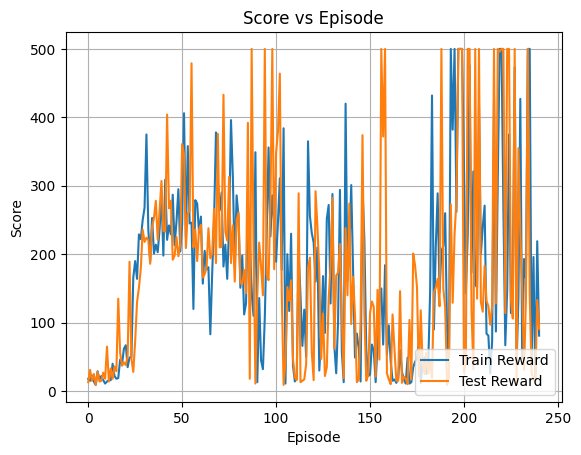

In [70]:
# plotting score vs episode

plt.plot(scores, label='Train Reward')
plt.plot(test_scores, label='Test Reward')
plt.legend(loc='lower right')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Score vs Episode')
plt.grid()
plt.show()